<br>

<h1 style="text-align:center;">Movie Recommendation System</h1>

<br>

## Introduction

---

In this project, we aim to develop a sophisticated movie recommendation system. Our goal is to be able to predict ratings for movies a user has not yet watched. The movies with the highest predicted ratings can then be recommended to the user.

In [1]:
# Import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, optimizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [2]:
# Set plt style
plt.style.use('ggplot')

<br>

## Load Dataset

---

The MovieLens ratings dataset lists the ratings given by a set of users to a set of movies.

Source: https://www.kaggle.com/c/movielens-100k

In [3]:
# Load the links data (i.e., linking to other sources of movie data such as IMDB, TMDb)
links_df = pd.read_csv('./dataset/links.csv')
links_df

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0
...,...,...,...
9737,193581,5476944,432131.0
9738,193583,5914996,445030.0
9739,193585,6397426,479308.0
9740,193587,8391976,483455.0


In [4]:
# Load the movies data (i.e., movie titles and genres)
movies_df = pd.read_csv('./dataset/movies.csv')
movies_df

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [5]:
# Load the ratings data (i.e., user ratings of movies)
ratings_df = pd.read_csv('./dataset/ratings.csv')
ratings_df

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [6]:
# Load the tags data (i.e., user tags of movies)
tags_df = pd.read_csv('./dataset/tags.csv')
tags_df

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200
...,...,...,...,...
3678,606,7382,for katie,1171234019
3679,606,7936,austere,1173392334
3680,610,3265,gun fu,1493843984
3681,610,3265,heroic bloodshed,1493843978


<br>

## Data Prepration and Preprocessing

---

In this section, we will prepare the data for modeling.

In [7]:
df = ratings_df.copy()

df

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [8]:
# Encoding user and movie IDs
user_ids, movie_ids = ratings_df["userId"].unique(), ratings_df["movieId"].unique()
user2user_encoded = {id: i for i, id in enumerate(user_ids)}
movie2movie_encoded = {id: i for i, id in enumerate(movie_ids)}
ratings_df["user"] = ratings_df["userId"].map(user2user_encoded)
ratings_df["movie"] = ratings_df["movieId"].map(movie2movie_encoded)

ratings_df

,userId,movieId,rating,timestamp,user,movie
0,1,1,4.0,964982703,0,0
1,1,3,4.0,964981247,0,1
2,1,6,4.0,964982224,0,2
3,1,47,5.0,964983815,0,3
4,1,50,5.0,964982931,0,4
...,...,...,...,...,...,...
100831,610,166534,4.0,1493848402,609,3120
100832,610,168248,5.0,1493850091,609,2035
100833,610,168250,5.0,1494273047,609,3121
100834,610,168252,5.0,1493846352,609,1392


In [9]:
# Statistics
num_users, num_movies = len(user_ids), len(movie_ids)
min_rating, max_rating = ratings_df["rating"].min(), ratings_df["rating"].max()

print(f"Number of users: {num_users}, Number of Movies: {num_movies}, Min rating: {min_rating}, Max rating: {max_rating}")

Number of users: 610, Number of Movies: 9724, Min rating: 0.5, Max rating: 5.0


In [10]:
# Normalize the ratings
scaler = MinMaxScaler()
ratings_df['rating'] = scaler.fit_transform(ratings_df[['rating']])

In [11]:
# Shuffle the data
ratings_df = ratings_df.sample(frac=1, random_state=42)
ratings_df

,userId,movieId,rating,timestamp,user,movie
67037,432,77866,0.888889,1335139641,431,4730
42175,288,474,0.555556,978465565,287,474
93850,599,4351,0.555556,1498524542,598,2631
6187,42,2987,0.777778,996262677,41,194
12229,75,1610,0.777778,1158989841,74,727
...,...,...,...,...,...,...
6265,42,4005,0.777778,996259059,41,1873
54886,364,141,0.777778,869443367,363,524
76820,480,6867,0.777778,1179163171,479,2240
860,6,981,0.555556,845556567,5,712


In [12]:
# Set features and target
x = ratings_df[["user", "movie"]].values
y = ratings_df["rating"].values

In [13]:
# Split the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.1, random_state=42)

<br>

## Modeling

---

In this section, we will implement the model for recommendation system.

In [14]:
# Hyperparameters
EMBEDDING_SIZE = 50

In [15]:
# User embedding layer
user_embedding_layer = layers.Embedding(
    input_dim=num_users,  
    output_dim=EMBEDDING_SIZE, 
    embeddings_initializer="he_normal",  
    embeddings_regularizer=regularizers.l2(1e-6),  
    name="user_embedding"
)

# User bias embedding layer
user_bias_layer = layers.Embedding(
    input_dim=num_users, 
    output_dim=1,
    name="user_bias"
) 

# Movie embedding layer 
movie_embedding_layer = layers.Embedding(
    input_dim=num_movies,  
    output_dim=EMBEDDING_SIZE, 
    embeddings_initializer="he_normal", 
    embeddings_regularizer=regularizers.l2(1e-6),
    name="movie_embedding"
)

# Movie bias embedding layer 
movie_bias_layer = layers.Embedding(
    input_dim=num_movies, 
    output_dim=1,
    name="movie_bias"
)

In [16]:
# Named input layer for user and movie IDs
inputs = layers.Input(shape=(2,), name="user_movie_input")

In [17]:
# Feed the user id to the user embedding and user bias layers
user_vector = user_embedding_layer(inputs[:, 0])  
user_bias = user_bias_layer(inputs[:, 0]) 

# Feed the movie id to the movie embedding and movie bias layers
movie_vector = movie_embedding_layer(inputs[:, 1])  
movie_bias = movie_bias_layer(inputs[:, 1])  

In [18]:
# Dot product for measuring similarity score between user and movie vectors
dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)  

# Add the user bias, movie bias, and dot product together
x = dot_user_movie + user_bias + movie_bias  

# Apply sigmoid (to get output between 0 and 1)
outputs = tf.nn.sigmoid(x)  

In [19]:
# Create the model with specified inputs and outputs
model = models.Model(inputs=inputs, outputs=outputs)

In [20]:
# Model summary
model.summary() 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_movie_input (InputLayer)  [(None, 2)]          0           []                               
                                                                                                  
 tf.__operators__.getitem (Slic  (None,)             0           ['user_movie_input[0][0]']       
 ingOpLambda)                                                                                     
                                                                                                  
 tf.__operators__.getitem_2 (Sl  (None,)             0           ['user_movie_input[0][0]']       
 icingOpLambda)                                                                                   
                                                                                              

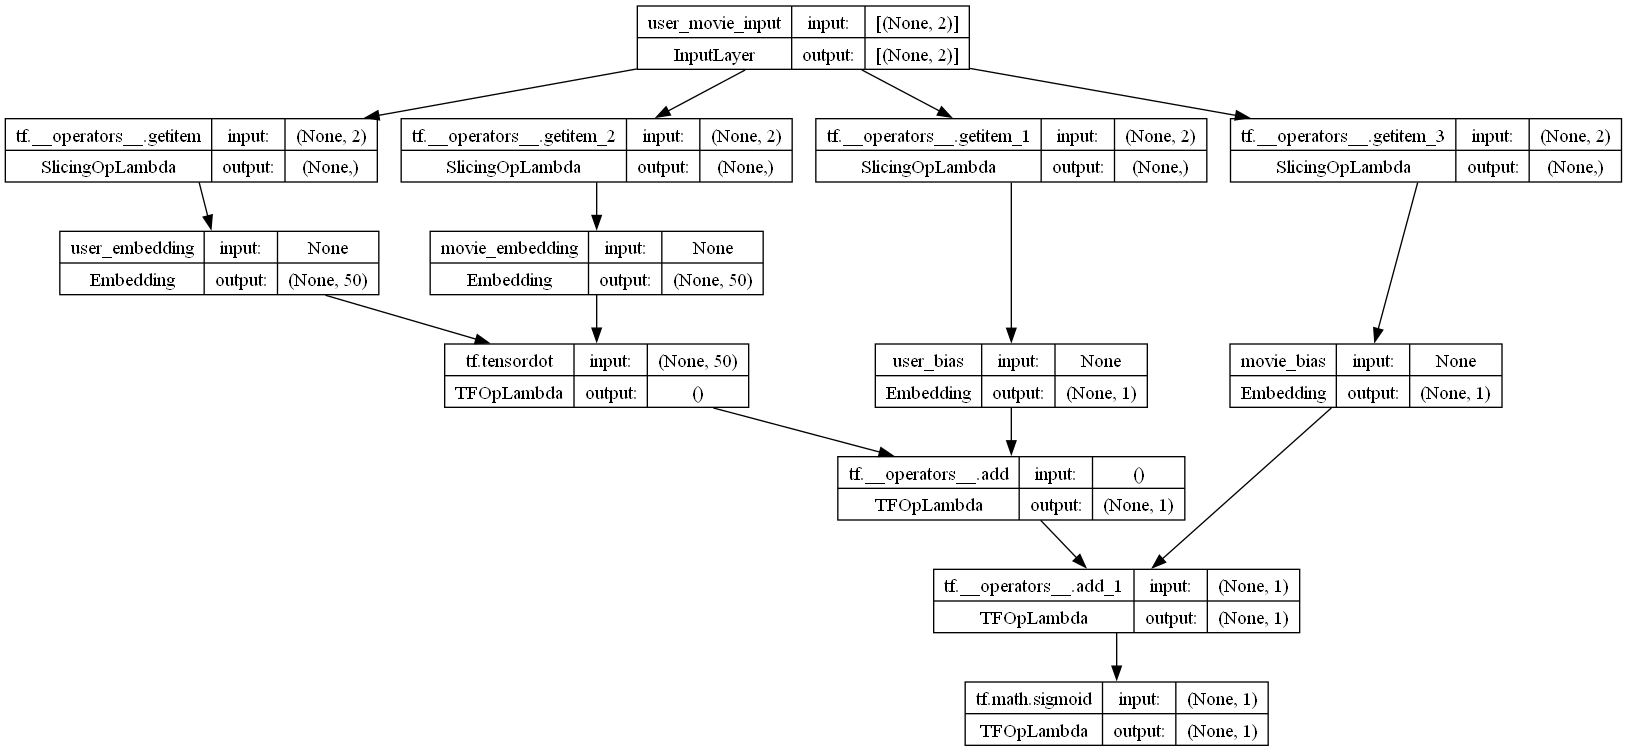

In [21]:
# Visualize the model
plot_model(model, to_file='model.png', show_shapes=True)

In [22]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True),
    ModelCheckpoint(filepath='checkpoints/best_model.h5', monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, min_lr=0.0001)
]

# Compile the model
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(learning_rate=0.001),
)

# Train the model with callbacks
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=20,
    verbose=1,
    validation_data=(x_val, y_val),
    callbacks=callbacks  
)

Epoch 1/20
1416/1418 [============================>.] - ETA: 0s - loss: 0.6364
Epoch 1: val_loss improved from inf to 0.61911, saving model to checkpoints\best_model.h5
1418/1418 [==============================] - 8s 5ms/step - loss: 0.6364 - val_loss: 0.6191 - lr: 0.0010
Epoch 2/20
1418/1418 [==============================] - ETA: 0s - loss: 0.6136
Epoch 2: val_loss improved from 0.61911 to 0.61595, saving model to checkpoints\best_model.h5
1418/1418 [==============================] - 7s 5ms/step - loss: 0.6136 - val_loss: 0.6159 - lr: 0.0010
Epoch 3/20
1411/1418 [============================>.] - ETA: 0s - loss: 0.6086
Epoch 3: val_loss improved from 0.61595 to 0.61131, saving model to checkpoints\best_model.h5
1418/1418 [==============================] - 7s 5ms/step - loss: 0.6087 - val_loss: 0.6113 - lr: 0.0010
Epoch 4/20
1406/1418 [============================>.] - ETA: 0s - loss: 0.6079
Epoch 4: val_loss improved from 0.61131 to 0.61049, saving model to checkpoints\best_model.h5


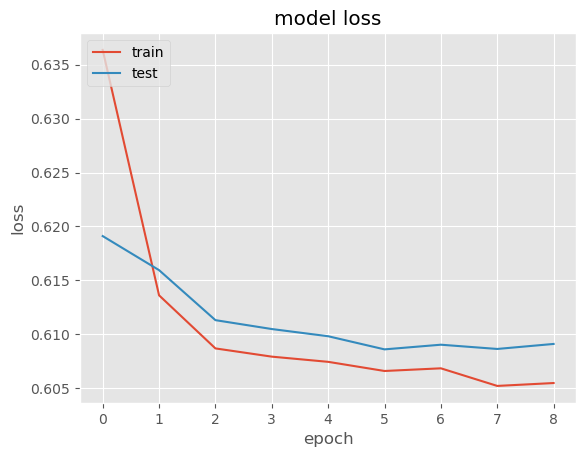

In [23]:
# Plot training and validation loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

<br>

## Prediction (Recommend Movies)

---

In this section, we will show top 10 movie recommendations to a user

In [24]:
def fetch_top_recommendations(user_id, interactions_df, movies_df, recommendation_model, user_to_encoded, movie_to_encoded, encoded_to_movie):
    """
    Returns top movie recommendations for a given user.
    
    Parameters:
    - user_id: ID of the user for whom recommendations are to be generated.
    - interactions_df: DataFrame containing user-movie interactions.
    - movies_df: DataFrame containing movie details.
    - recommendation_model: Trained recommendation model.
    - user_to_encoded: Mapping of user ID to user encoding.
    - movie_to_encoded: Mapping of movie ID to movie encoding.
    - encoded_to_movie: Mapping of movie encoding back to movie ID.
    
    Returns:
    List of recommended movie IDs.
    """

    # Find movies already watched by the user
    watched_movies = interactions_df[interactions_df.userId == user_id]
    
    # Identify movies not watched by the user, ensuring they are in the model's training data
    unwatched_movies = movies_df[~movies_df["movieId"].isin(watched_movies.movieId.values)]["movieId"]
    unwatched_movies = list(set(unwatched_movies).intersection(set(movie_to_encoded.keys())))
    
    # Encode the IDs of movies not watched for model input
    unwatched_movies_encoded = [[movie_to_encoded.get(x)] for x in unwatched_movies]
    
    # Encode the user ID for model input
    user_encoded = user_to_encoded.get(user_id)
    
    # Prepare model input array combining encoded user ID with encoded movie IDs
    user_movie_array = np.hstack(([[user_encoded]] * len(unwatched_movies_encoded), unwatched_movies_encoded))
    
    # Predict ratings for movies not watched by the user
    predicted_ratings = recommendation_model.predict(user_movie_array).flatten()
    
    # Identify the top 10 movie recommendations based on predicted ratings
    top_ratings_indices = predicted_ratings.argsort()[-10:][::-1]
    recommended_movie_ids = [encoded_to_movie.get(unwatched_movies_encoded[x][0]) for x in top_ratings_indices]
    
    # Return the IDs of the top recommended movies
    return recommended_movie_ids

In [41]:
# Optimized function to display recommendations
def display_recommendations(user_id, watched_movies, recommended_movie_ids, movies_df):
    """
    Prints watched movies and recommendations for the user in a user-friendly manner.
    
    Parameters:
    - user_id: ID of the user.
    - watched_movies: DataFrame of movies watched by the user.
    - recommended_movie_ids: List of recommended movie IDs.
    - movies_df: DataFrame containing movie details.
    """
    print(f"\nRecommendations for User ID: {user_id}")
    print("=" * 50)
    
    # Display top 5 high-rated movies watched by the user
    print("\nYou've enjoyed these movies:")
    top_watched_movies = watched_movies.sort_values(by="rating", ascending=False).head(5).movieId.values
    top_movies_details = movies_df[movies_df["movieId"].isin(top_watched_movies)]
    for index, row in enumerate(top_movies_details.itertuples(), start=1):
        print(f"{index}. {row.title} - Genres: {row.genres}")
    
    print("\n", "-" * 50)
    
    # Display top 10 recommended movies
    print("\nWe think you'll like these too:")
    recommended_movies_details = movies_df[movies_df["movieId"].isin(recommended_movie_ids)].head(10)
    for index, row in enumerate(recommended_movies_details.itertuples(), start=1):
        print(f"{index}. {row.title} - Genres: {row.genres}")

    print("=" * 50)

In [42]:
# Example usage

# User ID (randomly select)
user_id = ratings_df.userId.sample(1).iloc[0]  

# Fetching movies watched by the sampled user
watched_movies = ratings_df[ratings_df.userId == user_id] 

# Recommending movies to the sampled user
recommended_movie_ids = fetch_top_recommendations(
    user_id, 
    ratings_df, 
    movies_df, 
    model, 
    user2user_encoded, 
    movie2movie_encoded, 
    {value: key for key, value in movie2movie_encoded.items()}
)

# Display the recommendations
display_recommendations(user_id, watched_movies, recommended_movie_ids, movies_df)

291/291 [==============================] - 1s 2ms/step

Recommendations for User ID: 160

You've enjoyed these movies:
1. Star Wars: Episode IV - A New Hope (1977) - Genres: Action|Adventure|Sci-Fi
2. Fargo (1996) - Genres: Comedy|Crime|Drama|Thriller
3. Cinderella (1950) - Genres: Animation|Children|Fantasy|Musical|Romance
4. Dark City (1998) - Genres: Adventure|Film-Noir|Sci-Fi|Thriller
5. Chicken Run (2000) - Genres: Animation|Children|Comedy

 --------------------------------------------------

We think you'll like these too:
1. Shawshank Redemption, The (1994) - Genres: Crime|Drama
2. Casablanca (1942) - Genres: Drama|Romance
3. Reservoir Dogs (1992) - Genres: Crime|Mystery|Thriller
4. Streetcar Named Desire, A (1951) - Genres: Drama
5. One Flew Over the Cuckoo's Nest (1975) - Genres: Drama
6. Princess Bride, The (1987) - Genres: Action|Adventure|Comedy|Fantasy|Romance
7. Good, the Bad and the Ugly, The (Buono, il brutto, il cattivo, Il) (1966) - Genres: Action|Adventure|Western
8